In [16]:
pip install statsmodels

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [18]:
!git clone "https://github.com/HarshvardhanSingh-13/Datasets"

fatal: destination path 'Datasets' already exists and is not an empty directory.


In [19]:
df = pd.read_csv('/content/Datasets/Airline Timeseries/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


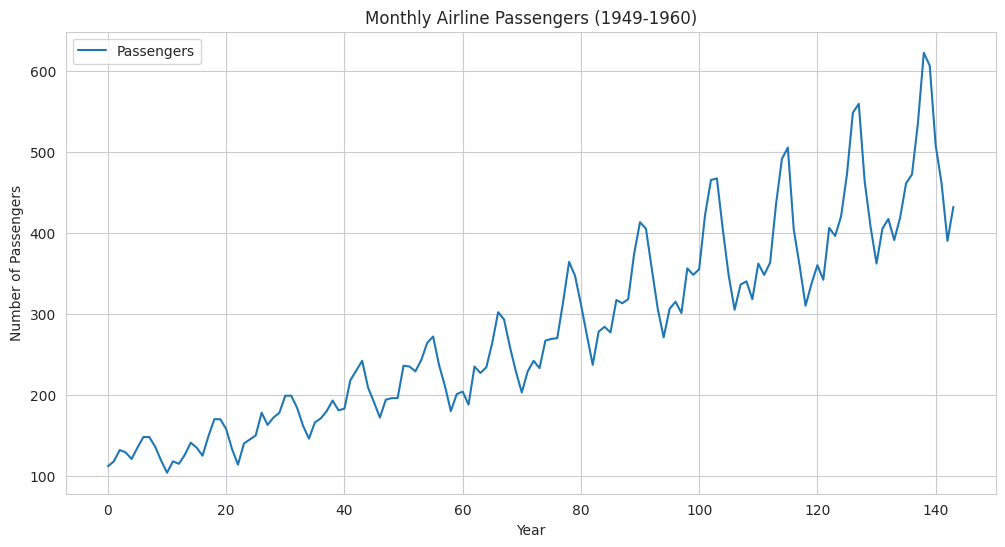

In [20]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

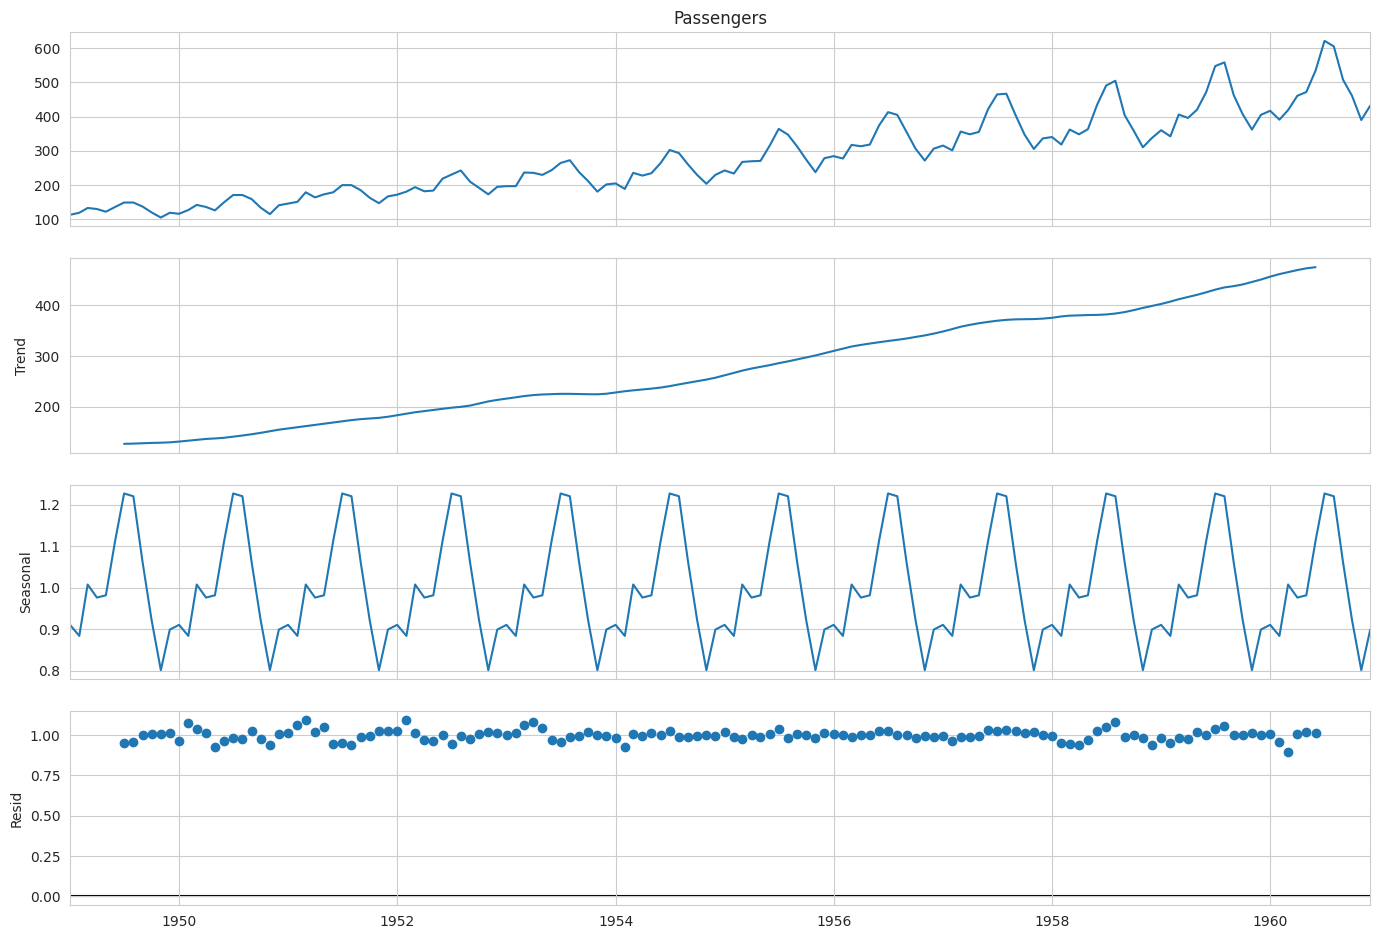

In [21]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [22]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Check if p-value condition is satisfied
    p_value = dftest[1]
    if p_value > 0.05:
        print(f"\np-value = {p_value:.4f} → p-value > 0.05, series is Non-Stationary.")
        print("Applying first-order differencing to make it stationary...\n")

        # Apply differencing
        diff_series = timeseries.diff().dropna()

        # Re-run ADF test on differenced series
        print("Results of Dickey-Fuller Test (after differencing):")
        dftest_diff = adfuller(diff_series, autolag='AIC')
        dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest_diff[4].items():
            dfoutput_diff['Critical Value (%s)'%key] = value
        print(dfoutput_diff)

        p_value_diff = dftest_diff[1]
        if p_value_diff < 0.05:
            print(f"\np-value = {p_value_diff:.4f} → p-value < 0.05, series is now Stationary.")
        else:
            print(f"\np-value = {p_value_diff:.4f} → Still non-stationary. May need further differencing.")

        return diff_series
    else:
        print(f"\np-value = {p_value:.4f} → p-value < 0.05, series is already Stationary.")
        return timeseries

stationary_series = test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

p-value = 0.9919 → p-value > 0.05, series is Non-Stationary.
Applying first-order differencing to make it stationary...

Results of Dickey-Fuller Test (after differencing):
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

p-value = 0.0542 → Still non-stationary. May need further differencing.


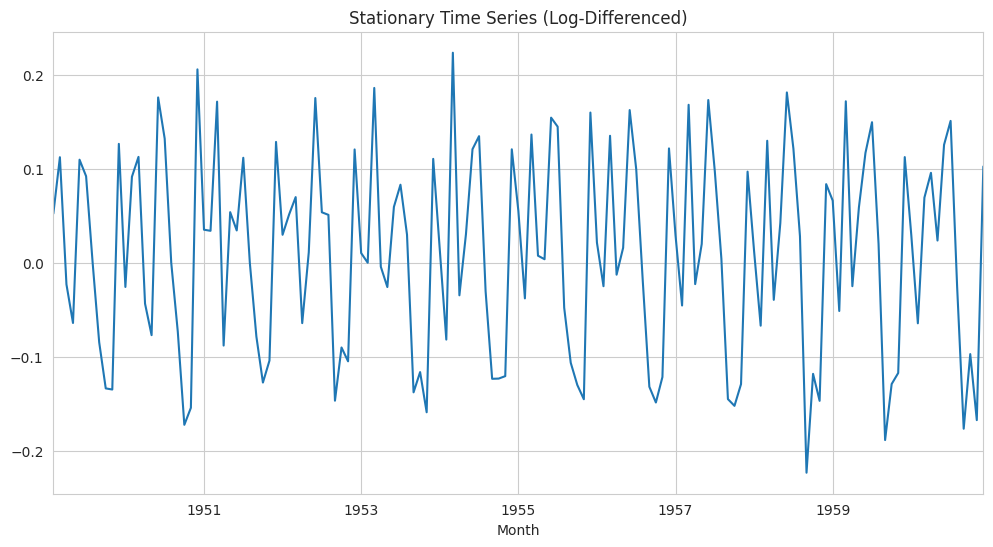

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

p-value = 0.0711 → p-value > 0.05, series is Non-Stationary.
Applying first-order differencing to make it stationary...

Results of Dickey-Fuller Test (after differencing):
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64

p-value = 0.0000 → p-value < 0.05, series is now Stationary.


,Passengers
Month,
1949-03-01,0.059932
1949-04-01,-0.135107
1949-05-01,-0.041032
1949-06-01,0.173506
1949-07-01,-0.017547
...,...
1960-08-01,-0.176733
1960-09-01,-0.150338
1960-10-01,0.079315


In [23]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

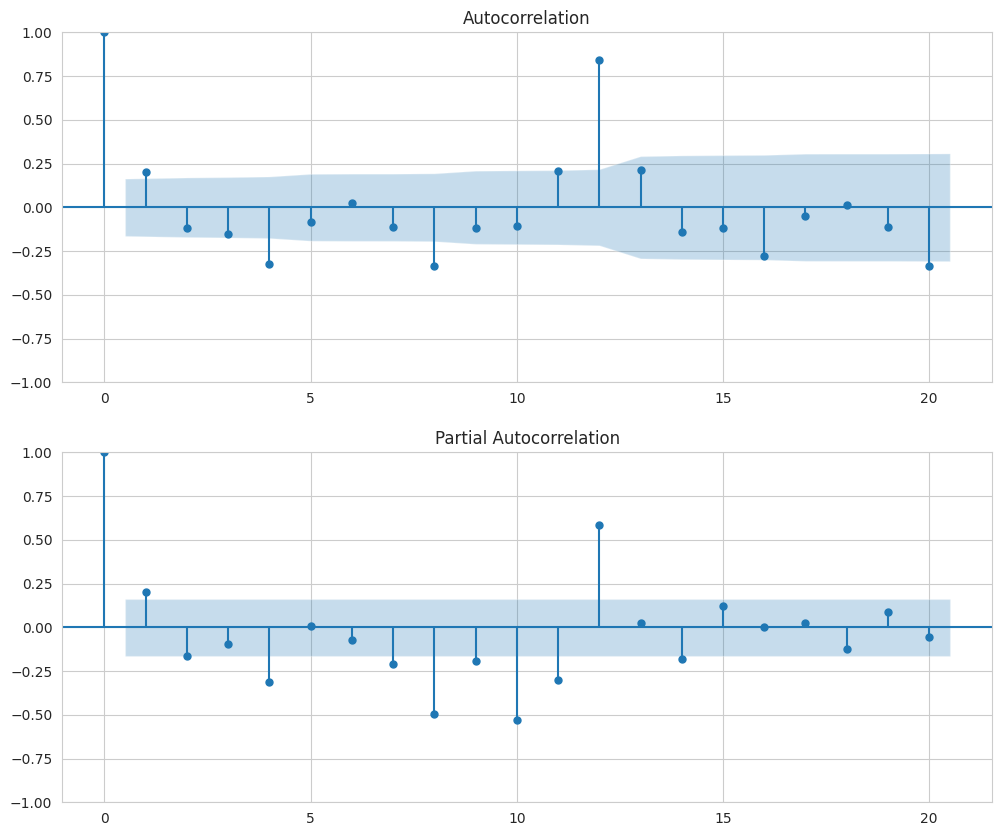

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model Coefficients Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5760      0.191     -3.014      0.003      -0.951      -0.201
ma.L1          0.8347      0.117      7.130      0.000       0.605       1.064
sigma2         0.0102      0.002      5.556      0.000       0.007       0.014

p-values of coefficients:
ar.L1     2.580468e-03
ma.L1     1.003914e-12
sigma2    2.759746e-08
dtype: float64

All coefficient p-values < 0.05 ✓ Model is good!


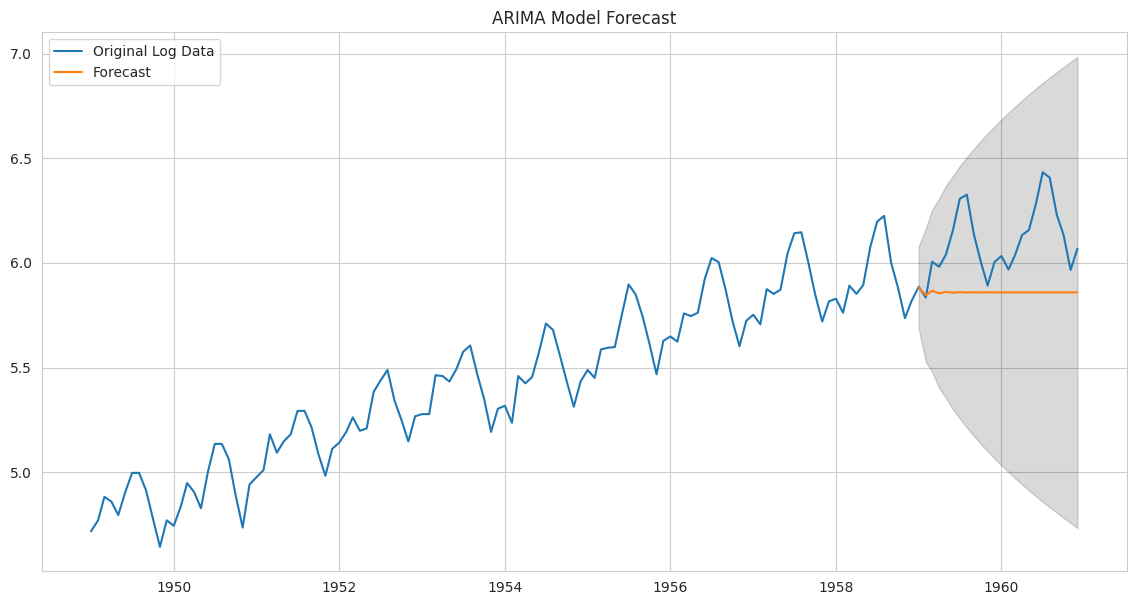

In [25]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Check p-values of model coefficients
print("Model Coefficients Summary:")
print(arima_result.summary().tables[1])

p_values = arima_result.pvalues
print("\np-values of coefficients:")
print(p_values)

# Check if all p-values are below 0.05
if (p_values > 0.05).any():
    print("\nSome coefficients have p-value > 0.05. Trying different orders...\n")

    best_model = None
    best_aic = float('inf')
    best_order = None

    for p in range(0, 4):
        for q in range(0, 4):
            try:
                temp_model = ARIMA(train_data, order=(p, 1, q), freq='MS')
                temp_result = temp_model.fit()

                # Only consider models where all p-values < 0.05
                if (temp_result.pvalues < 0.05).all():
                    if temp_result.aic < best_aic:
                        best_aic = temp_result.aic
                        best_order = (p, 1, q)
                        best_model = temp_result
            except:
                continue

    if best_model is not None:
        print(f"Best order found: {best_order} with AIC = {best_aic:.2f}")
        arima_result = best_model
    else:
        print("No order found with all p-values < 0.05. Keeping original (1,1,1).")
else:
    print("\nAll coefficient p-values < 0.05 ✓ Model is good!")

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA Model Coefficients Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.255      0.201      0.841      -0.448       0.551
ma.L1         -0.4649      0.235     -1.979      0.048      -0.925      -0.004
ar.S.L12      -0.3805      0.181     -2.098      0.036      -0.736      -0.025
ma.S.L12      -0.1069      0.224     -0.477      0.633      -0.546       0.332
sigma2         0.0015      0.000      7.239      0.000       0.001       0.002

p-values of coefficients:
ar.L1       8.407469e-01
ma.L1       4.784369e-02
ar.S.L12    3.592530e-02
ma.S.L12    6.331952e-01
sigma2      4.536279e-13
dtype: float64

Some coefficients have p-value > 0.05. Running grid search...

Best order found: ARIMA(1, 1, 0) x SEASONAL(0, 1, 0)[12]
AIC = -359.98

Best Model Coefficients Summary:
                 coef    std err          z      P>|z|      [0.025      0.97

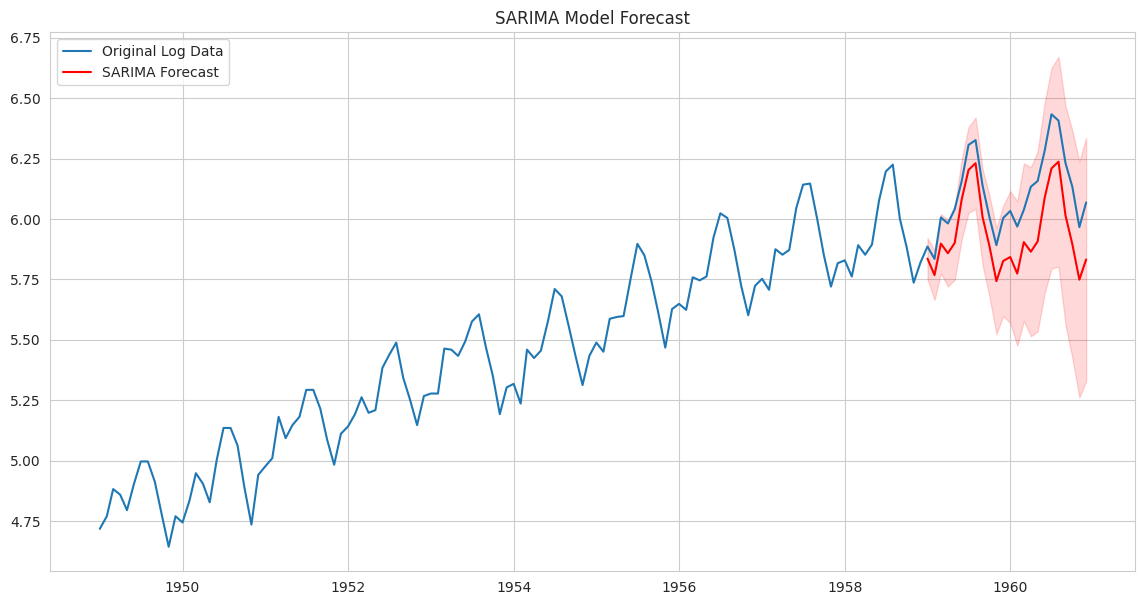

In [26]:
import warnings

# Build SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sarima_result = sarima_model.fit(disp=False)

# Check p-values of model coefficients
print("SARIMA Model Coefficients Summary:")
print(sarima_result.summary().tables[1])

p_values = sarima_result.pvalues
print("\np-values of coefficients:")
print(p_values)

# Check if all p-values are below 0.05
if (p_values > 0.05).any():
    print("\nSome coefficients have p-value > 0.05. Running grid search...\n")

    best_model = None
    best_aic = float('inf')
    best_order = None

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for p in range(0, 3):
            for q in range(0, 3):
                for P in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            temp_model = sm.tsa.statespace.SARIMAX(
                                train_data,
                                order=(p, 1, q),
                                seasonal_order=(P, 1, Q, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq='MS'
                            )
                            temp_result = temp_model.fit(disp=False)

                            # Only consider models where all p-values < 0.05
                            if (temp_result.pvalues < 0.05).all():
                                if temp_result.aic < best_aic:
                                    best_aic = temp_result.aic
                                    best_order = (p, 1, q, P, 1, Q)
                                    best_model = temp_result
                        except:
                            continue

    if best_model is not None:
        print(f"Best order found: ARIMA{best_order[:3]} x SEASONAL{best_order[3:]}[12]")
        print(f"AIC = {best_aic:.2f}")
        print("\nBest Model Coefficients Summary:")
        print(best_model.summary().tables[1])
        sarima_result = best_model
    else:
        print("No combination found with all p-values < 0.05. Keeping original (1,1,1)(1,1,1)[12].")
else:
    print("\nAll coefficient p-values < 0.05 ✓ Model is good!")

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

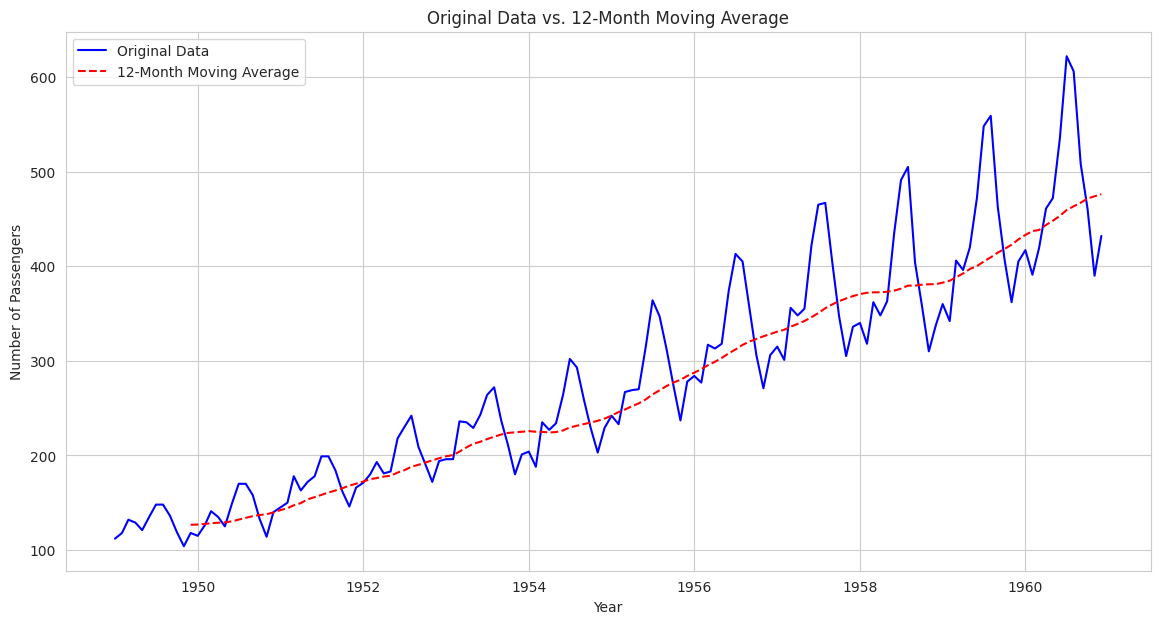

In [27]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


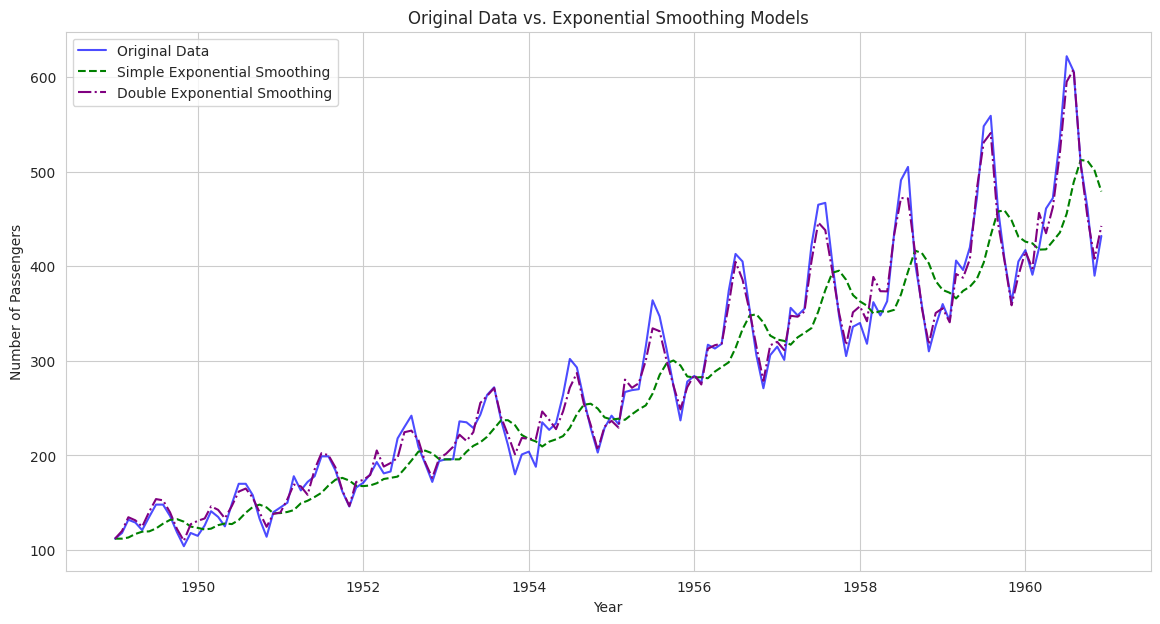

In [28]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Some coefficients have p-value > 0.05. Running grid search for better model...

Best model: ARIMA(1, 1, 0) x SEASONAL(0, 1, 0)[12], AIC = -359.98


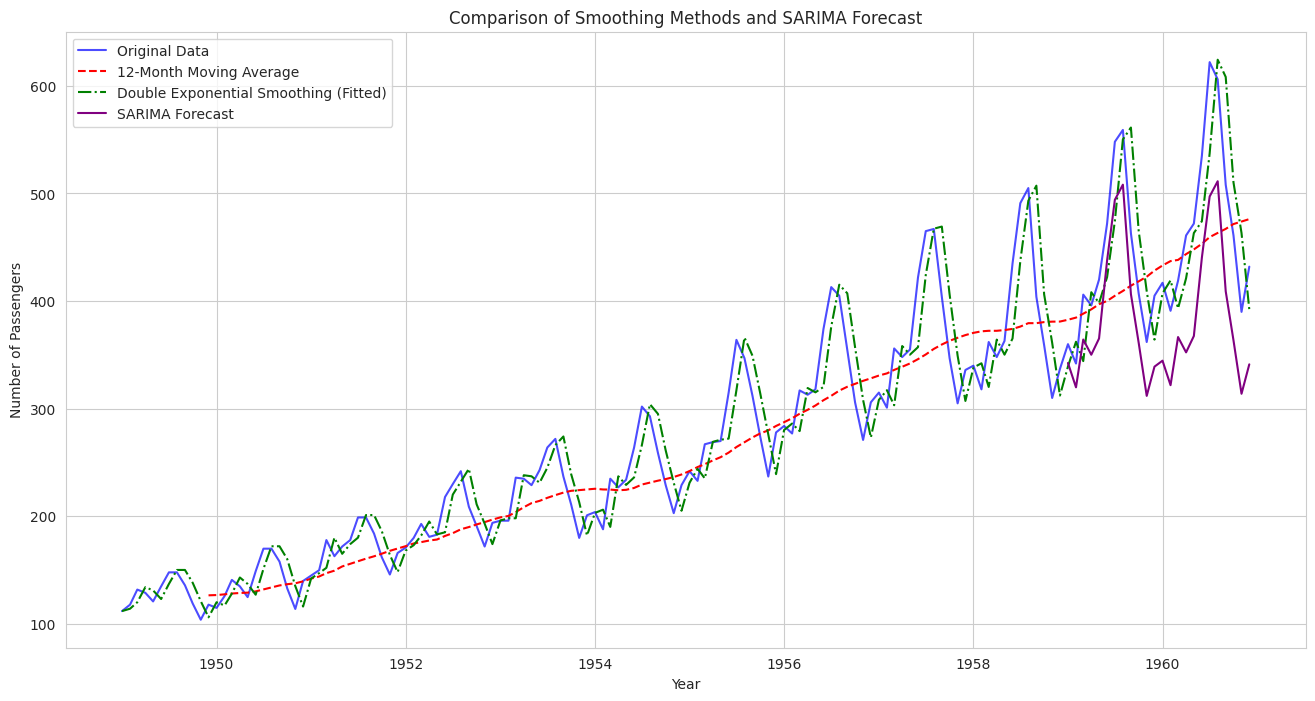

In [29]:
# Implement Double Exponential Smoothing for comparison
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

# Fit Double Exponential Smoothing model on the entire data for visualization
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]

sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sarima_result = sarima_model.fit(disp=False)

# Check p-values
p_values = sarima_result.pvalues

if (p_values > 0.05).any():
    print("Some coefficients have p-value > 0.05. Running grid search for better model...\n")

    best_model = None
    best_aic = float('inf')
    best_order = None

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for p in range(0, 3):
            for q in range(0, 3):
                for P in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            temp_model = sm.tsa.statespace.SARIMAX(
                                train_data,
                                order=(p, 1, q),
                                seasonal_order=(P, 1, Q, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq='MS'
                            )
                            temp_result = temp_model.fit(disp=False)

                            if (temp_result.pvalues < 0.05).all():
                                if temp_result.aic < best_aic:
                                    best_aic = temp_result.aic
                                    best_order = (p, 1, q, P, 1, Q)
                                    best_model = temp_result
                        except:
                            continue

    if best_model is not None:
        print(f"Best model: ARIMA{best_order[:3]} x SEASONAL{best_order[3:]}[12], AIC = {best_aic:.2f}")
        sarima_result = best_model
    else:
        print("No better model found. Using original (1,1,1)(1,1,1)[12].")
else:
    print("All coefficient p-values < 0.05 ✓")

sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)

# Generate comparison plot
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')
plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()